In [1]:
import numpy as np
import pandas as pd

from fractions import Fraction
from collections import defaultdict, Counter
from iteration_utilities import deepflatten #flatten nested lists


from music21 import midi, note, stream, instrument, meter, key
import itertools
import random


import nltk #for NLP
import string
import mchmm #for Markov models

#Just a helper function
def flatten_list(hierarchical_list):
    #Flatten a list of lists
    return [x for sublist in hierarchical_list for x in sublist]

# Helper functions

In this tutorial, we use the library `music21` to visualize rhythms in score format. Music21 stores `Note` objects into containers (e.g., a `Measure` or a `Stream`). The parameters of the note objects (e.g., duration, onset, and pitch) can be transformed algorithmically, and the conteiners can then be visualized in score format or rendered as audio playback in midi format.

First, here is a shortcut for **playback**:

In [38]:
def play(score):
    #Shortcut to play a stream
    midi.realtime.StreamPlayer(score).play()

**Now, we define a function to create percussion sounds that we can embed in streams.**

First, let us create a note object of given duration. 

We express durations in whole-note units, so that quarter-notes have duration 1/4, eigth-notes have duration 1/8 etc. You can easily change the duration unit by assigning a new value to the UNIT variable.

Since we are dealing with rhythm, we don't really care about the pitch of the notes, so we assign a default value (C4). When calling the percussion_hit function, you can either stick to the default pitch (just omit the pitch parameter) or you can specify a new value for the pitch parameter.

In [3]:
#GLOBAL CONSTANTS
UNIT = 1 #We express duration as fractions of a whole note. Use UNIT = 1/4 to express durations as fractions of quarter-notes

def percussion_hit(duration, pitch = "C4"):
    #Create Note object for percussion hits (default pitch is C4)
    return note.Note(pitch, quarterLength = duration*(4*UNIT))

So, a percussion_hit of duration 1 (whole-note) spans 4 quarter-notes:

In [4]:
percussion_hit(1).quarterLength

4.0

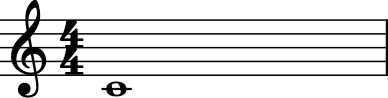

In [5]:
percussion_hit(1).show()

**Now, we create a container object (a Stream or a Measure) for our percussion_hits.**

By default, no time signature is specified, so that a single measure of unspecified capacity is generated. If you do specify a time signature when calling the create_percussion function, a stream with the given time signature is created instead.

In [39]:
def create_percussion(time_sig = None):
    #Initialize a percussion stream with Woodblock timbre
    #If time signature is None, no measure splits
    if time_sig == None:
        drumPart = stream.Measure()
    else:
        drumPart = stream.Stream()
        drumPart.timeSignature = meter.TimeSignature(time_sig)
    
    drumPart.insert(0, instrument.Woodblock()) #assign woodblock timbre
    return drumPart

**We can now embed a percussion_hit in a stream.**

To simplify the process, we define new functions that append a percussion_hit of given duration to a percussion stream:

In [40]:
def append_event(duration, original_stream, rest = False, pitch = 'C4'):
    #Returns a new_stream obtained by appending a rhythmical event or a rest of given duration to the original_stream
    new_stream = original_stream
    if rest:
        new_stream.append(note.Rest(quarterLength = duration*(4*UNIT)))
    else:
        new_stream.append(percussion_hit(duration, pitch))
    return new_stream


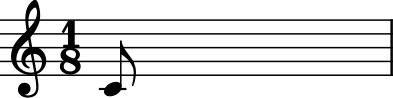

In [8]:
m = create_percussion()
append_event(1/8, m).show()

Finally, we define a function to generate a rhythm directly from a list of durations:

In [11]:
def rhythm_from_sequence(durations, time_sig = None, pitch = 'C4', rhythm=None):
    #Generate rhythmic stream from a list of durations. Rests are indicated by specifying a duration as a string
    if rhythm is None:
        # pass an existing stream 'rhythm' to append the durations, otherwise a new one will be created
        rhythm = create_percussion(time_sig = time_sig)
    for dur in durations:
        is_rest = False
        if dur != 0:
            if isinstance(dur, str):
                #if duration is given as a string, interpret and rest and turn string into a numerical value
                is_rest = True
                dur = Fraction(dur)
            
            rhythm = append_event(dur, rhythm, rest = is_rest, pitch = pitch) 
    return rhythm


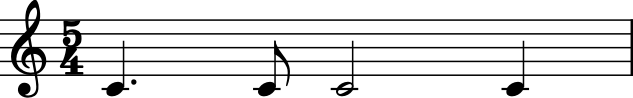

In [44]:
rhythm_from_sequence([3/8, 1/8, 1/2, 1/4]).show()

# Hierarchical generation of rhythm

In a Markov model, each rhythmic event depends on the preceding one(s). A different approach to modelling rhythm is to interpret rhythmic events as recursive elaborations of a latent rhythmic structure. The following example of hierarchical rhythm generation is based on the grammar from Rohrmeier (2020) https://program.ismir2020.net/poster_4-20.html.

## Rhythmic objects

First, in this formalism, a rhythmic category is a 3-ple of parameters defining a time-span: the upbeat, the body and the tail. The body represents the "ideal" duration of the timespan, if no extensions or timestealing happen. The upbeat encodes the addition (if positive) or subtraction (if negative) of a portion at the beginning of the timespan. Similarly, the coda encodes the addition (if positive) or subtraction (if negative) of a portion at the end of the timespan. As a consequence, the overall duration of a timespan (a, b, c) is a+b+c. 

Each rhythmic category can generate other rhythmic categories by means of the application of a rule.

In [45]:
class rhythmic_category:
    def __init__(self, upbeat, body, tail):
        #Parameters
        self.upbeat = upbeat
        self.body = body
        self.tail = tail
        self.parameters = (upbeat, body, tail)
       
    def showScore(self):
        #A helper function to display the rhythmic category. Shows a positive upbeat separately from the body+tail
        sequence = [self.upbeat, self.body + self.tail]
        if self.upbeat < 0:
            sequence[0] = 0
            sequence[1] += self.upbeat
            
        return rhythm_from_sequence(sequence).show()
        
        
    
        
    ####    
    #Rule applications
    ####
    
    def split(self, ratio = 1/2, right_child_upbeat = 0):
        #SPLIT operation on parent metrical category, based on ratio = left_child_body/parent.body. 
        #An upbeat for the right child can be specified.
        left_child_body = self.body*ratio
        right_child_body = self.body-left_child_body
    
        left_child_cat = rhythmic_category(self.upbeat, left_child_body, - right_child_upbeat)
        right_child_cat = rhythmic_category(right_child_upbeat, right_child_body, self.tail)
    
        return list(deepflatten([left_child_cat, right_child_cat]))
    
    def prepare(self):
        #UPBEAT rule: separates upbeat from body
        if self.upbeat > 0:
            left_child_cat = rhythmic_category(0, self.upbeat, 0)
            right_child_cat = rhythmic_category(0, self.body, self.tail)
    
            return list(deepflatten([left_child_cat,  right_child_cat]))
        else:
            return [self]
        
    def e_shift(self):
        #ANTICIPATE rule: shifts body to the left
        return [rhythmic_category(0, self.body, self.upbeat+self.tail)]
    
    def l_shift(self):
        #DELAY rule: shifts body to the right
        return [rhythmic_category(self.upbeat + self.tail, self.body, 0)]
    
    ####
    #Helpers to derive terminal durations at the end of a derivation
    ####
    
    def timesteal(self):
        #TIMESTEALING. If a category is left with negative upbeat or tail, subtract it from the body
        new_upbeat = self.upbeat
        new_tail = self.tail
        timestolen_body = self.body
        if self.upbeat < 0:
            new_upbeat = 0
            timestolen_body += self.upbeat
        if self.tail < 0:
            new_tail = 0
            timestolen_body += self.tail
        return [rhythmic_category(new_upbeat, timestolen_body, new_tail)]
    
    def attach_tail(self):
        #Attach tail to body, to be used if tail > 0
        return [rhythmic_category(self.upbeat, self.body+self.tail, 0)]

    
    def get_terminals(self):
    #Recursively get terminal durations from metrical categories.
    #ARBITRARY CONVENTIONS TO TERMINATE DERIVATION: If there is negative head or tail, interpret as timestealing. If there is positive head, interpret as preparation. If there is positive tail, attch it to the body.
    
        if (self.upbeat == 0) and (self.tail == 0):
            return [self.body]
        elif (self.upbeat < 0) | (self.tail < 0):
            return  list(deepflatten([x.get_terminals() for x in self.timesteal()]))
        elif self.tail > 0:
            return  list(deepflatten([x.get_terminals() for x in self.attach_tail()]))
        elif self.upbeat > 0:
            return list(deepflatten([x.get_terminals() for x in self.prepare()]))
    
        
        

For example, here is a rhythmic category:

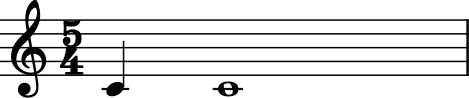

In [13]:
example_category = rhythmic_category(1/4, 1, 0)
example_category.showScore()

Rules can be applied to have this "parent" category generate other categories as its own "children".

**Split**. This rule splits a rhythmic category into two "children" by dividing the body into two parts. The left child inherits the upbeat of the parent category, while the right child inherits the coda of the parent category. Finally, the right child might "steal" a portion from the left child (if the right child has a positive upbeat), or vice-versa (if the right child has a negative upbeat). The split rule comes with two parameters. First, the split ratio (which is often 1/2, representing an equal split). The second parameter is optional, and specifies the upbeat of the right child (default is 0).

In [14]:
splitted_example = example_category.split(1/2)
splitted_example

In [15]:
[child.parameters for child in splitted_example]

[(0.25, 0.5, 0), (0, 0.5, 0)]

Note that this is an equal split where the children do not steal time from each other. Here we have a different split, where the right child has an upbeat, hence stealing time from the left child:

In [16]:
splitted_example_with_upbeat = example_category.split(1/2, 1/16)
[child.parameters for child in splitted_example_with_upbeat]

[(0.25, 0.5, -0.0625), (0.0625, 0.5, 0)]

**Prepare**. This rule separates the upbeat (if it is positive) from the body, creating two distinct rhytmic categories: one inherits the parent's upbeat as its own body, the other inherits the parent's body and tail (but has not upbeat).

In [17]:
[child.parameters for child in example_category.prepare()]

[(0, 0.25, 0), (0, 1, 0)]

**Anticipate and Delay**: these two rules are unary rules, i.e. the parent is simply transformed into one different category. In the anticipation (or e-shift) rule, the upbeat is absorbed into the body, so that the body of the timespan is shifted to the left. The delay (or l-shift) rule does the opposite.

Here is, for example, an application of the anticipation rule. Since this is a unary rule, only one child is generated:

In [18]:
[child.parameters for child in example_category.e_shift()]

[(0, 1, 0.25)]

## Generation

Starting with a "root" rhythmic category, we can apply these rules recursively to generate a rhythm within the timespan of the root.

Let us first define some useful functions.

The `rule` function just specifies a rule to be applied, with its parameters.

In [19]:
def rule(rule_type, p1 = None, p2 = None):
    #Returns dictionary specifying a rule with its parameters
    
    rule_def = {'type': rule_type}
    
    if p1 != None:
        rule_def['p1'] = p1
    if p2 != None:
        rule_def['p2'] = p2
    
    return rule_def
    

The `generate_hierarchical_rhythm` function is the most important one. In order to generate a rhythm, we need a root category and a recipe that specifies what rules are to be applied (and in what order). Given a recipe and a root category, this function reads the recipe and applies the required rules recursively to the children, grand-children, grand-grand-children etc. of the root category.  

In [20]:
def generate_hierarchical_rhythm(tree, starting_symbol, preterminal_string = []):
    #Recursively generate rhythm from a hierarchy of rule applications
    
    #If node is a pre-terminal, add it to the list of pre-terminals...
    if len(tree) == 0:
        return preterminal_string + [starting_symbol]
    
    #...otherwise, apply the rule associated with that node
    else:
        rule = tree[0]
        if rule['type'] == 'split':
            children = starting_symbol.split(ratio = rule['p1'], right_child_upbeat = rule['p2'])
        elif rule['type'] == 'prepare':
            children = starting_symbol.prepare()
        elif rule['type'] == 'anticipate':
            children = starting_symbol.e_shift()
        elif rule['type'] == 'delay':
            children = starting_symbol.l_shift()
            
        #Call generate_hierarchical_rhythm recursively for all children of the current node   
        for child_n in range(len(children)):
            preterminal_string = generate_hierarchical_rhythm(tree[child_n+1], children[child_n], preterminal_string = preterminal_string)
                
    
        return preterminal_string
    

The last few functions just help to turn the output of `generate_hierarchical_rhythm` into a list of durations, and to turn this list of durations into a music21 stream.

In [21]:
def get_terminal_durations(rhythmic_categories):
    #Turns list of pre-terminal categories in list of terminal durations
    return list(deepflatten([x.get_terminals() for x in rhythmic_categories]))


def hierarchical_rhythm(tree, starting_symbol):
    #generate list of durations hierarchically
    return get_terminal_durations(generate_hierarchical_rhythm(tree, starting_symbol))

def rhythm(tree, starting_symbol, time_sig = None):
    #Show score  
    return rhythm_from_sequence(hierarchical_rhythm(tree, starting_symbol), time_sig = time_sig)
    

Here, as an example, we generate the initial rhythm from the Jazz standard "Blue Bossa" (Rohrmeier 2020) 
https://youtu.be/U7eOs5lERww?t=12

<img src="BlueBossa.png">

The rhythm lasts 4 bars (in 4/4 meter) plus a 1/4 upbeat, so that the root category is:

In [24]:
root = rhythmic_category(1/4, 4, 0)

<img src="bb01.png">
The recipe to generate a rhythm can be represented in the form of a derivation tree. Each node of the tree is occupied by a rhythmic category, and the branches originating at a node lead to the children of that node under some rule application. A full derivation tree for the example from Blue Bossa is the following: 

<img src="HierarchicalRhythm.png">

Let us start from the top of the tree, where we find the root category. The first branching is a split rule (the body is split in half), leading to two children nodes. We can represent a node of the tree as a list, containing the rule applied at that node (if any), as well as its children nodes. In the case of the topmost node in the above tree, the rule is a split with ratio 1/2 and right-child's head 1/4. Since we are not applying any rule to the two children nodes (yet), they are represented as empty lists. 

In [25]:
tree = [rule('split',1/2, 1/4), #root
            [], #left child of the root
            []  #right child of the root
       ]

The function `rhythm` takes a tree and a root as arguments and returns a music21 stream with the resulting rhythm. In order to do that, it calls the recursive function `generate_hierarchical_rhythm` that reads the tree and applies the rule applications, starting with the root category.

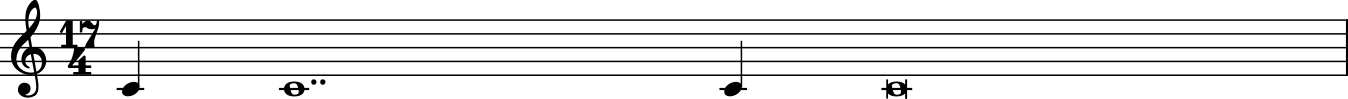

In [28]:
generated_rhythm = rhythm(tree, root)
generated_rhythm.show()

<img src="bb02.png">
Let's look now at the left child of the root node. Here, another split rule is applied, resulting in two children with equal body (split factor 1/2) and a 1/8 upbeat for the right child. 

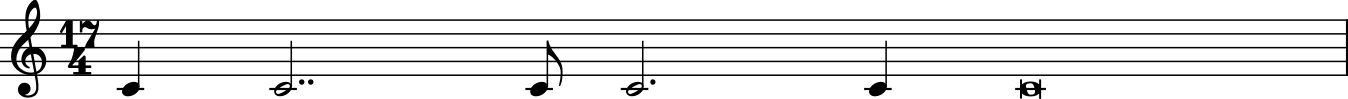

pygame 2.0.0 (SDL 2.0.12, python 3.7.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [30]:
tree = [rule('split',1/2, 1/4), #root
            [rule('split', 1/2, 1/8), #left child of the root
                 [], #left child of the left child of the root
                 []  #right child of the left child of the root
            ],
            [] #right child of the root
       ]
generated_rhythm = rhythm(tree, root)
generated_rhythm.show()
play(generated_rhythm)

<img src="bb03.png">
The left child of the left child of the root also undergoes a split operation...

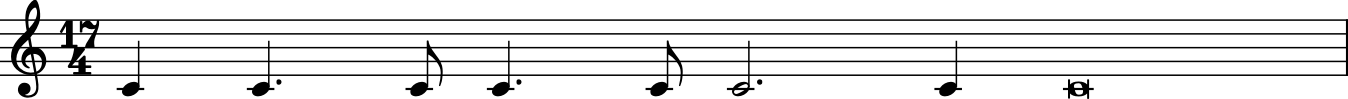

In [31]:
tree = [rule('split',1/2, 1/4), #root
            [rule('split', 1/2, 1/8), #left child of the root
                 [rule('split', 1/2, 1/8), #left child of the left child of the root
                      [], #left child of the left child of the left child of the root
                      []  #right child of the left child of the left child of the root
                 ],
                 [] #right child of the left child of the root
            ],
            [] #right child of the root
       ]
generated_rhythm = rhythm(tree, root)
generated_rhythm.show()
play(generated_rhythm)

<img src="bb04.png">
... while its own left child (i.e., of the left child of the left child of the root) undergoes a preparation rule...

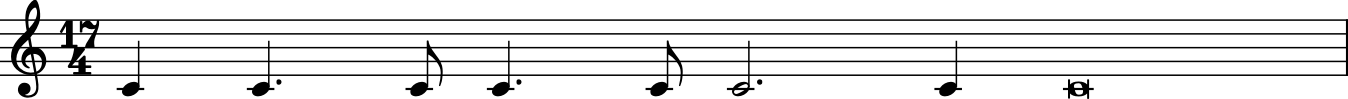

In [33]:
tree = [rule('split',1/2, 1/4), #root
            [rule('split', 1/2, 1/8), #left child of the root
                 [rule('split', 1/2, 1/8), #left child of the left child of the root
                      [rule('prepare'), #left child of the left child of the left child of the root
                           [], #left child of the left child of the left child of the left child of the root
                           []  #right child of the left child of the left child of the left child of the root
                      ],
                      [] #right child of the left child of the left child of the root
                 ],
                 [] #right child of the left child of the root
            ],
            [] #right child of the root
       ]
generated_rhythm = rhythm(tree, root)
generated_rhythm.show()
play(generated_rhythm)

... similarly to the right child of the left child of the left child of the root:

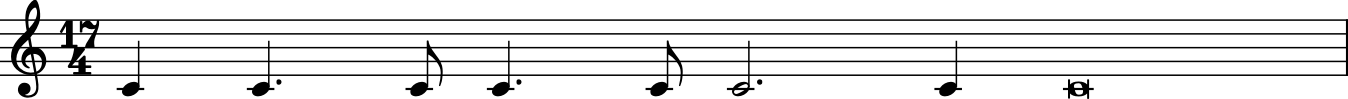

In [34]:
tree = [rule('split',1/2, 1/4),
            [rule('split', 1/2, 1/8),
                 [rule('split', 1/2, 1/8),
                      [rule('prepare'),
                           [],
                           []
                      ],
                      [rule('prepare'),
                           [],
                           []
                      ]
                 ],
                 []
            ],
            []
       ]
generated_rhythm = rhythm(tree, root)
generated_rhythm.show()
play(generated_rhythm)

The right child of this preparation rule is further elaborated with a split, whose right child is then anticipated:

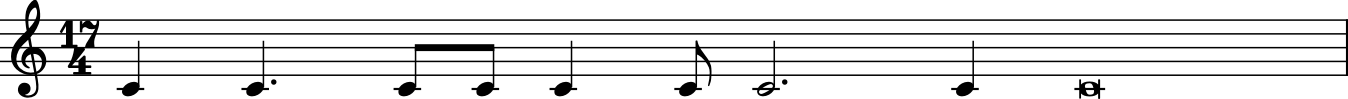

In [35]:
tree = [rule('split',1/2, 1/4),
            [rule('split', 1/2, 1/8),
                 [rule('split', 1/2, 1/8),
                      [rule('prepare'),
                           [],
                           []
                      ],
                      [rule('prepare'),
                           [],
                           [rule('split', 1/2, 1/8),
                                [],
                                [rule('anticipate'),
                                     []
                                ]
                           ]
                      ]
                 ],
                 []
            ],
            []
       ]
generated_rhythm = rhythm(tree, root)
generated_rhythm.show()
play(generated_rhythm)

<img src="bb06.png">
Fast-forward to the whole tree:

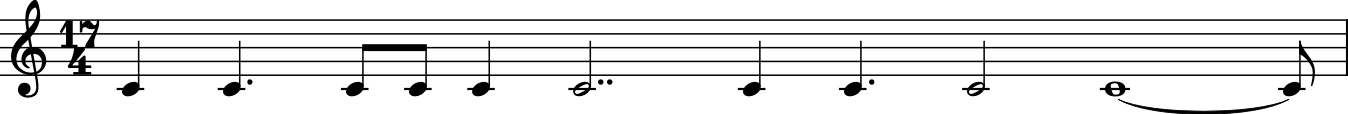

In [37]:
complete_tree = [rule('split',1/2, 1/4),
            [rule('split', 1/2, 1/8),
                 [rule('split', 1/2, 1/8),
                      [rule('prepare'),
                           [],
                           []
                      ],
                      [rule('prepare'),
                           [],
                           [rule('split', 1/2, 1/8),
                                [],
                                [rule('anticipate'),
                                     []
                                ]
                           ]
                      ]
                 ],
                 [rule('anticipate'),
                     []
                 ]
            ],
            [rule('split', 1/2, 1/8),
                 [rule('split', 1/2, 1/8),
                      [rule('prepare'),
                           [],
                           []
                      ],
                      [rule('anticipate'),
                           []
                      ]
                 ],
                 [rule('anticipate'),
                      []
                 ]
            ]
       ]

generated_rhythm_complete = rhythm(complete_tree, root)
generated_rhythm_complete.show()
play(generated_rhythm_complete)

<img src="bb07.png">

Overall, here is how all notes in the generated rhythm relate to each other in terms of generative steps: in yellow the splits, in blue the preparations, in green the anticipations. Orange boxes highlight places where some notes "steal time" from other notes (because of anticipations).

<img src="ColouredDerivation.png">